In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seml
import pandas as pd
import json
from collections import defaultdict
from functools import reduce
import seaborn as sns
from itertools import product
from scipy.stats import binned_statistic
from matplotlib.lines import Line2D

In [2]:
collection_name = 'week12_spectral_norm_cora_ml'
collection = seml.database.get_collection(collection_name)
experiments = [{'config' : r['config'], 'result' : r['result'], 'id' : r['_id']} for r in collection.find() if r['status'] in ('COMPLETED',)]
for ex in experiments:
    with open(ex['result']) as f:
        ex['result'] = json.load(f)

print(f'Number of finished experiments : {len(experiments)}')

Number of finished experiments : 152


In [3]:
SETTING = 'Setting'
RESIDUAL = 'Residual'
SPECTRAL_NORM = 'Spectral Normalzation'
NORMALIZE_OUTPUT = 'Spectral Output Normalization'
ACCURACY = 'Accuracy'
ECE = 'Expected Calibration Error'
WEIGHT_SCALE = 'Weight Scale'
LIPSCHITZ = 'Median Empirical Lipschitz Constant'
LIPSCHITZ_MAX = 'Empirical Upper Lipschitz Constant'
LIPSCHITZ_MIN = 'Empirical Lower Lipschitz Constant'
OOD = 'Out of Distribution Setting'
PROXY = 'Proxy'
LOC = 'LoC'
BERNOULLI = 'Bernoulli'
NORMAL = 'Normal'
GPC = 'Feature Density GPC'
MAX_SCORE = 'Max Softmax Score'
AUROC = 'AUC-ROC'
TRANSDUCTIVE = 'transductive'
HYBRID = 'hybrid'

In [4]:
list(ex['result'].keys())

['val_loss-val-0',
 'val_accuracy-val-0',
 'accuracy_val',
 'accuracy_id_val',
 'accuracy_ood_val',
 'accuracy_val_no-edges',
 'accuracy_id_val_no-edges',
 'accuracy_ood_val_no-edges',
 'ece_val',
 'ece_val_no-edges',
 'empirical_lipschitz_val_slope_mean_perturbation_noise',
 'empirical_lipschitz_val_slope_median_perturbation_noise',
 'empirical_lipschitz_val_slope_max_perturbation_noise',
 'empirical_lipschitz_val_slope_min_perturbation_noise',
 'empirical_lipschitz_val_slope_mean_perturbation_derangement',
 'empirical_lipschitz_val_slope_median_perturbation_derangement',
 'empirical_lipschitz_val_slope_max_perturbation_derangement',
 'empirical_lipschitz_val_slope_min_perturbation_derangement',
 'accuracy_ber_ber-no-edges',
 'accuracy_id_ber_ber-no-edges',
 'accuracy_ood_ber_ber-no-edges',
 'auroc_total-predictive-entropy_ber-no-edges',
 'aucpr_total-predictive-entropy_ber-no-edges',
 'auroc_max-score_ber-no-edges',
 'aucpr_max-score_ber-no-edges',
 'auroc_logit-energy_ber-no-edges',

In [5]:
data = []
data_auroc = []
for ex_idx, ex in enumerate(experiments):
    for idx in range(ex['config']['data']['num_dataset_splits'] * ex['config']['model']['num_initializations']):
        
        
        base = {
            SETTING : ex['config']['data']['setting'],
            RESIDUAL : ex['config']['model']['residual'],
            SPECTRAL_NORM : ex['config']['model']['use_spectral_norm'],
            WEIGHT_SCALE : (ex['config']['model']['weight_scale']),
            LIPSCHITZ : ex['result']['empirical_lipschitz_val_slope_median_perturbation_noise'][idx],
            LIPSCHITZ_MAX : ex['result']['empirical_lipschitz_val_slope_max_perturbation_noise'][idx],
            LIPSCHITZ_MIN : ex['result']['empirical_lipschitz_val_slope_min_perturbation_noise'][idx],
            '_EXPERIMENT_IDX' : ex_idx,
        }
        if ex['config']['model']['use_spectral_norm'] == False:
            # Duplicate the values for no spectral norm (once with and once without output normalization)
            base[NORMALIZE_OUTPUT] = False
            base[WEIGHT_SCALE] = np.nan
        else:
            base[NORMALIZE_OUTPUT] = ex['config']['model']['use_spectral_norm_on_last_layer']

        data.append(base | {
            ACCURACY : ex['result']['accuracy_val'][idx],
            ECE : ex['result']['ece_val'][idx],
        })
        for k in ex['result'].keys():
            if 'auroc' not in k or 'no-edges' in k: 
                continue
            if k.endswith('loc'):
                ood = LOC
            elif k.endswith('ber'):
                ood = BERNOULLI
            elif k.endswith('normal'):
                ood = NORMAL
            else:
                continue
            if 'gpc-diag-weighted:no' in k:
                data_auroc.append(base | {
                    PROXY : GPC,
                    AUROC : ex['result'][k][idx],
                    OOD : ood,
                })
            elif 'max-score' in k:
                data_auroc.append(base | {
                    PROXY : MAX_SCORE,
                    AUROC : ex['result'][k][idx],
                    OOD : ood,
                })
            else:
                continue
        
df = pd.DataFrame(data)
df_auroc = pd.DataFrame(data_auroc)
df_merged = pd.merge(df_auroc, df)

In [6]:
_confidence_interval = 95 # unused

In [7]:
def plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(df, x=None, y=None, row=None, col=None, hue=None, style=None, 
                                      ci=_confidence_interval, 
                                      facet_kws = {'margin_titles' : True, 'height' : 4, }, log_x = True):
    
    g = sns.FacetGrid(df, row = row, col = col, hue = hue, **facet_kws)
    
    styles = ['solid', 'dotted', 'dashed']
    markers = ['o', 'x', '+']
    label_to_color = {}
    style_to_linestyle = {}
    style_to_marker = {}
    style_name = style
    
    def plot_lines(x, y, style, sn, color=None, label=None, ci=95):
        label_to_color[label] = color
        
        for style_idx, st in enumerate(sorted(np.unique(style).tolist())):
            style_to_linestyle[st] = styles[style_idx]
            style_to_marker[st] = markers[style_idx]
            # Bin the ones without spectral norm according to lipschitz constant
            
            x_style, y_style = x[(style == st) & (sn == True)], y[(style == st) & (sn == True)]
            if log_x:
                x_style = np.log(x_style)
            
            mean, bin_edges, bin_idx = binned_statistic(x_style, y_style, statistic='mean', bins=10)
            std, _, _ = binned_statistic(x_style, y_style, bins=bin_edges, statistic='std')
            bin_centers = (0.5 * (bin_edges[:-1] + bin_edges[1:]))
            if log_x:
                bin_centers = np.exp(bin_centers)
            
            plot_mask = np.isfinite(mean) & np.isfinite(std)
            
            plt.plot(bin_centers[plot_mask], mean[plot_mask], color=color, label=f'{label}, {st}', linestyle=styles[style_idx])
            plt.fill_between(bin_centers[plot_mask],( mean - std)[plot_mask], (mean + std)[plot_mask], alpha = 0.2, color=color)
            
            # Put the ones without spectral norm into one bin put as a point
            x_style, y_style = x[(style == st) & (sn == False)], y[(style == st) & (sn == False)]
            x_std, y_std = x_style.std(), y_style.std()
            _x, _y = np.array([x_style.mean()]), np.array([y_style.mean()])
            if (np.isfinite(_x) & np.isfinite(_y)).all():
                plt.errorbar(_x, _y, yerr=y_style.std(), xerr = x_style.std(), ecolor='gray', capsize=2, fmt=markers[style_idx], color=color)
        
    g.map(plot_lines, x, y, style, SPECTRAL_NORM, ci=ci)
    
    # Create a legend (extremely hacky)
    
    lines, line_labels = [], []
    for label, color in label_to_color.items():
        lines.append(Line2D([0], [0], color=color))
        line_labels.append(label)
    l1 = plt.legend(lines, line_labels, title=hue, loc='center left', bbox_to_anchor=(1.1, 1.25))
    
    lines, line_labels = [], []
    for style, ls in style_to_linestyle.items():
        lines.append(Line2D([0], [0], color='black', ls=ls))
        line_labels.append(style)
    l2 = plt.legend(lines, line_labels, title=f'{style_name}', loc='center left', bbox_to_anchor=(1.1, 1.0))
    
    
    lines, line_labels = [], []
    for style, marker in style_to_marker.items():
        lines.append(plt.errorbar([], [], xerr=[], yerr=[], color='black', ecolor='gray', capsize=10, fmt=marker))
        line_labels.append(style)
    l3 = plt.legend(lines, line_labels, title=f'{style_name},\nNo Spectral Norm', loc='center left', bbox_to_anchor=(1.1, 0.75))
    
    g.axes.flatten()[-1].add_artist(l1)
    g.axes.flatten()[-1].add_artist(l2)
    
    
    if log_x:
        g.set(xscale='log')
    return g


In [8]:
_confidence_interval = 95 # Set to a value in percent or "sd"

## Effects of Weight Scale on Accuracy, Calibration and Lipschitz Constant

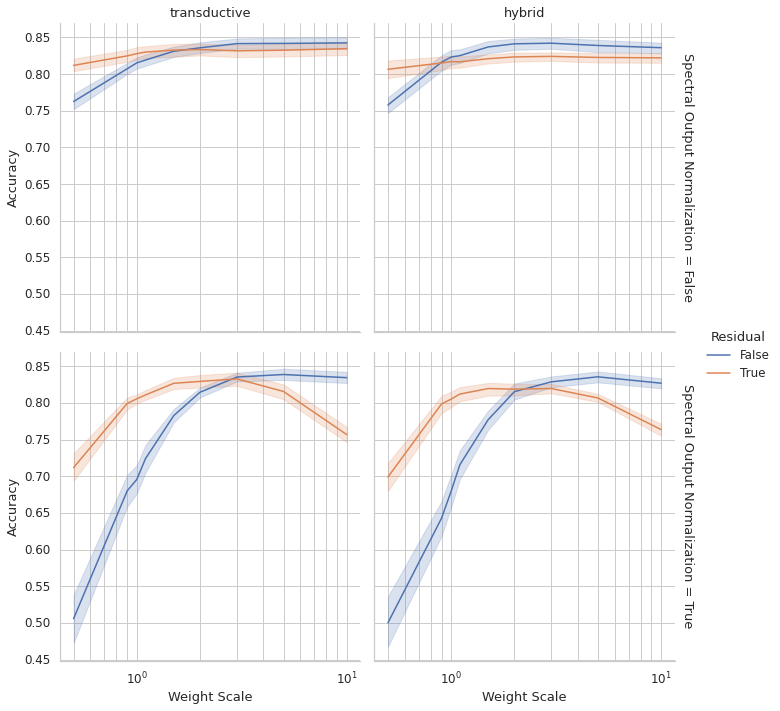

In [9]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df, x = WEIGHT_SCALE, y = ACCURACY, hue = RESIDUAL, col = SETTING, 
                row = NORMALIZE_OUTPUT, kind='line', facet_kws = {'margin_titles' : True}, ci=_confidence_interval)
g.set(xscale='log')
g.set_titles( col_template = '{col_name}')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

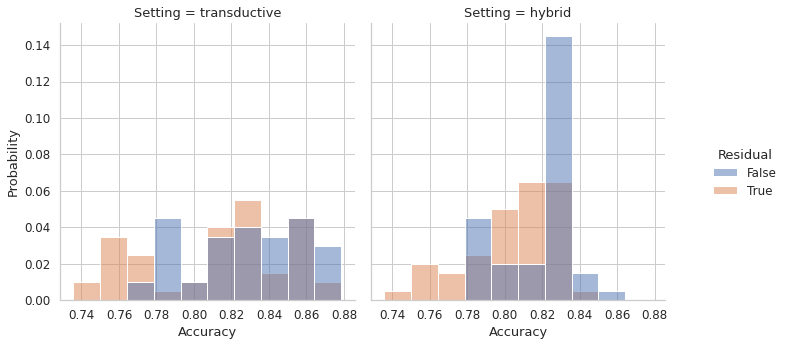

In [10]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.displot(data = df[df[SPECTRAL_NORM] == False], x=ACCURACY, hue = RESIDUAL, col = SETTING, 
                kind='hist', facet_kws = {'margin_titles' : True}, stat='probability')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

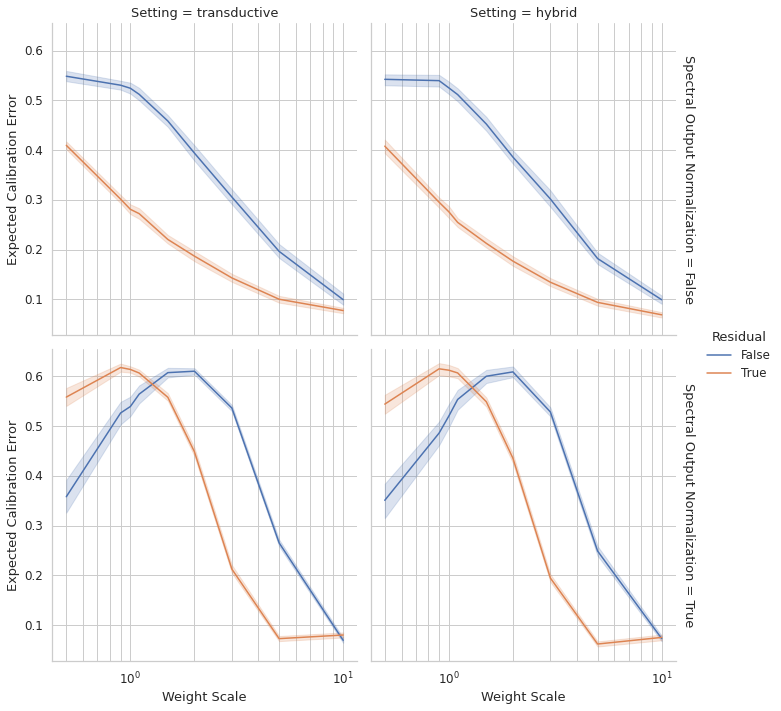

In [11]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df, x = WEIGHT_SCALE, y = ECE, hue = RESIDUAL, col = SETTING, 
                row = NORMALIZE_OUTPUT, kind='line', facet_kws = {'margin_titles' : True}, ci=_confidence_interval)
g.set(xscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

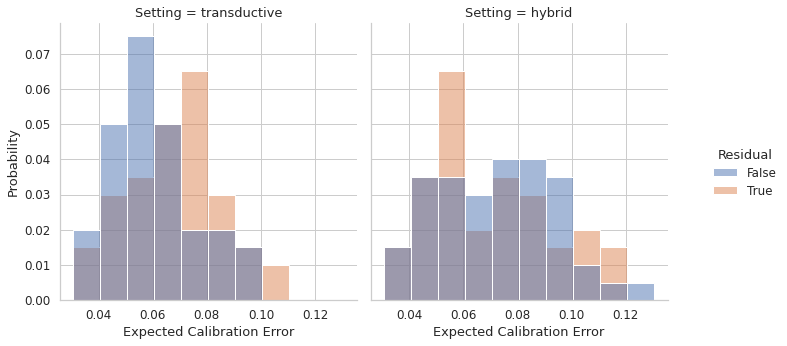

In [12]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.displot(data = df[df[SPECTRAL_NORM] == False], x=ECE, hue = RESIDUAL, col = SETTING, 
                kind='hist', facet_kws = {'margin_titles' : True}, stat='probability')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

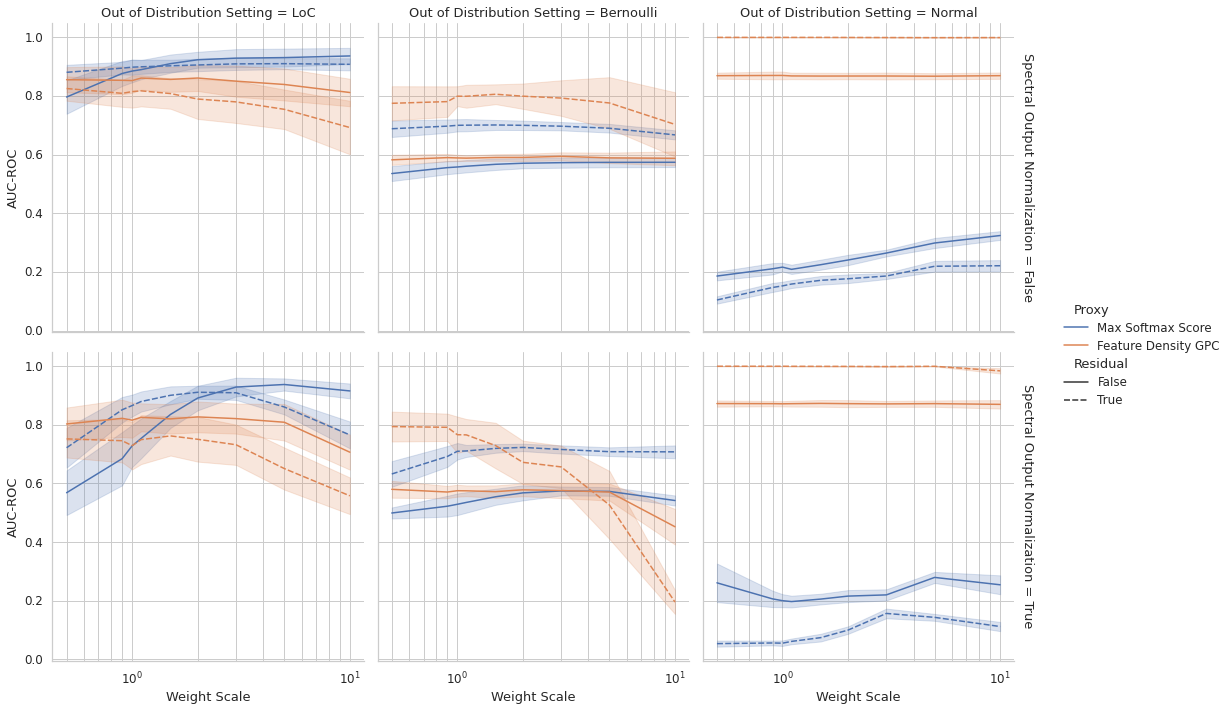

In [13]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df_auroc[df_auroc[SETTING] == HYBRID] , x = WEIGHT_SCALE, y = AUROC, hue = PROXY, col = OOD, 
                row = NORMALIZE_OUTPUT, kind='line', facet_kws = {'margin_titles' : True}, style=RESIDUAL, ci='sd')
g.set(xscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

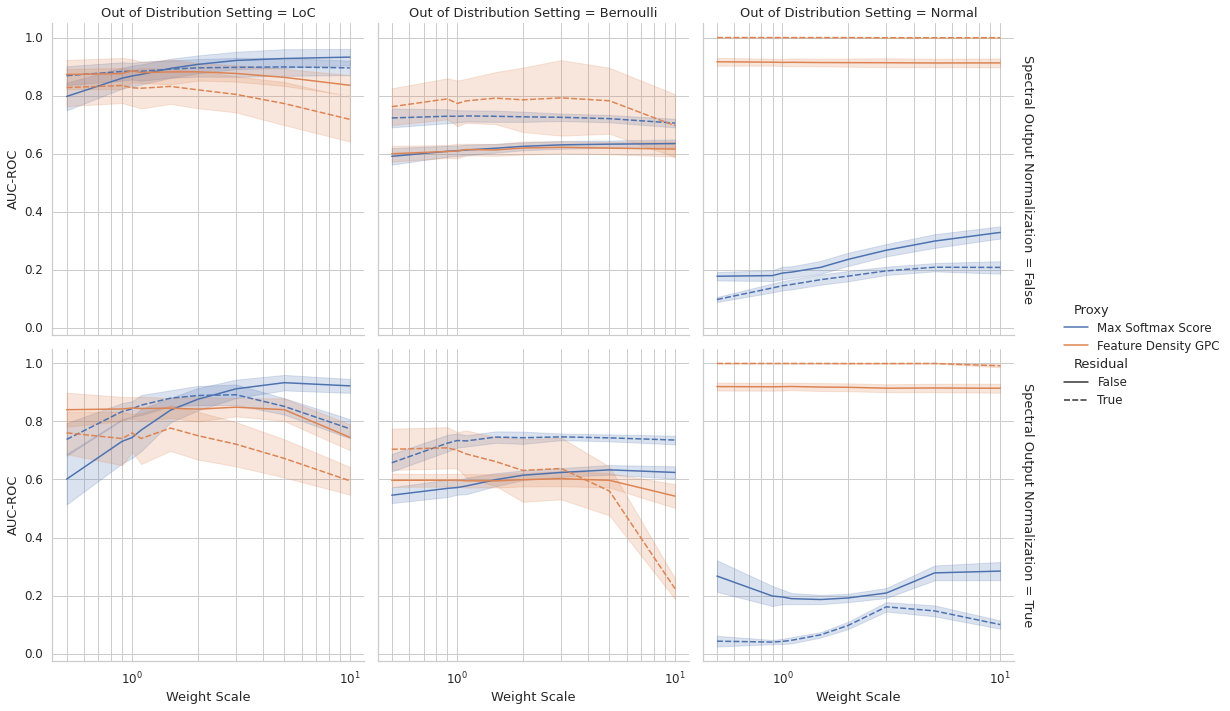

In [14]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df_auroc[df_auroc[SETTING] == TRANSDUCTIVE] , x = WEIGHT_SCALE, y = AUROC, hue = PROXY, col = OOD, 
                row = NORMALIZE_OUTPUT, kind='line', facet_kws = {'margin_titles' : True}, style=RESIDUAL, ci='sd')
g.set(xscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

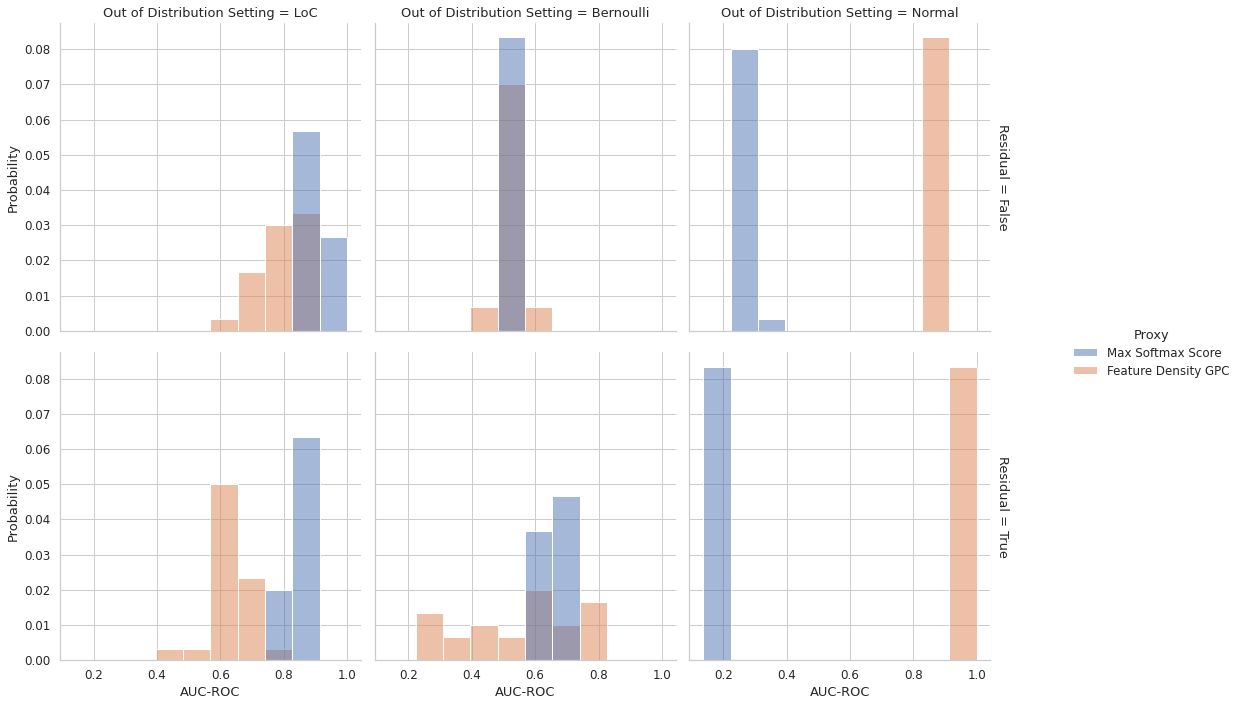

In [15]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.displot(data = df_auroc[
    (df_auroc[SPECTRAL_NORM] == False) & (df_auroc[SETTING] == HYBRID)
], x=AUROC, hue = PROXY, col = OOD, row=RESIDUAL, 
                kind='hist', facet_kws = {'margin_titles' : True}, stat='probability')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

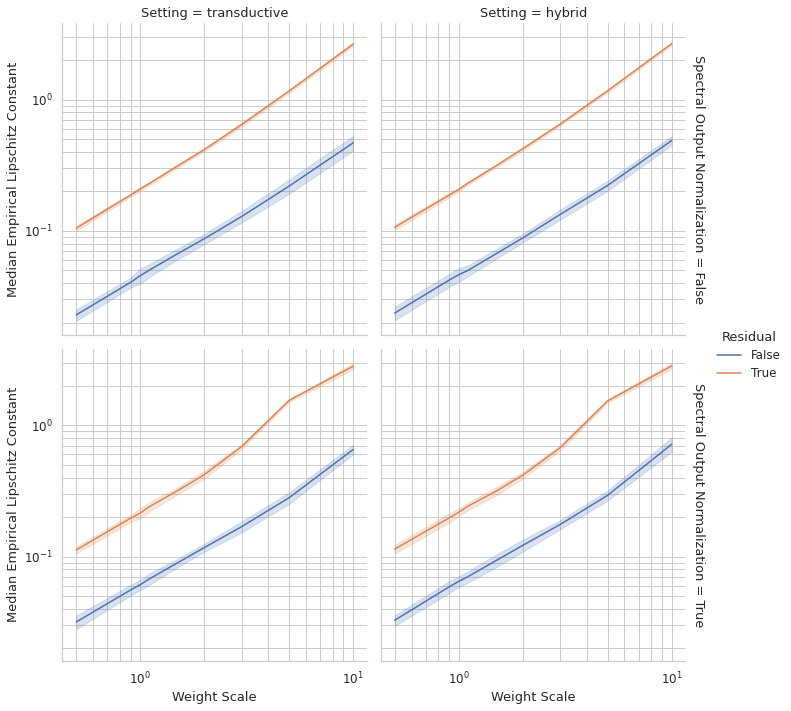

In [16]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df, x = WEIGHT_SCALE, y = LIPSCHITZ, hue = RESIDUAL, col = SETTING, 
                row = NORMALIZE_OUTPUT, kind='line', facet_kws = {'margin_titles' : True}, ci='sd')
g.set(xscale='log', yscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
    ax.yaxis.grid(True, which='minor')

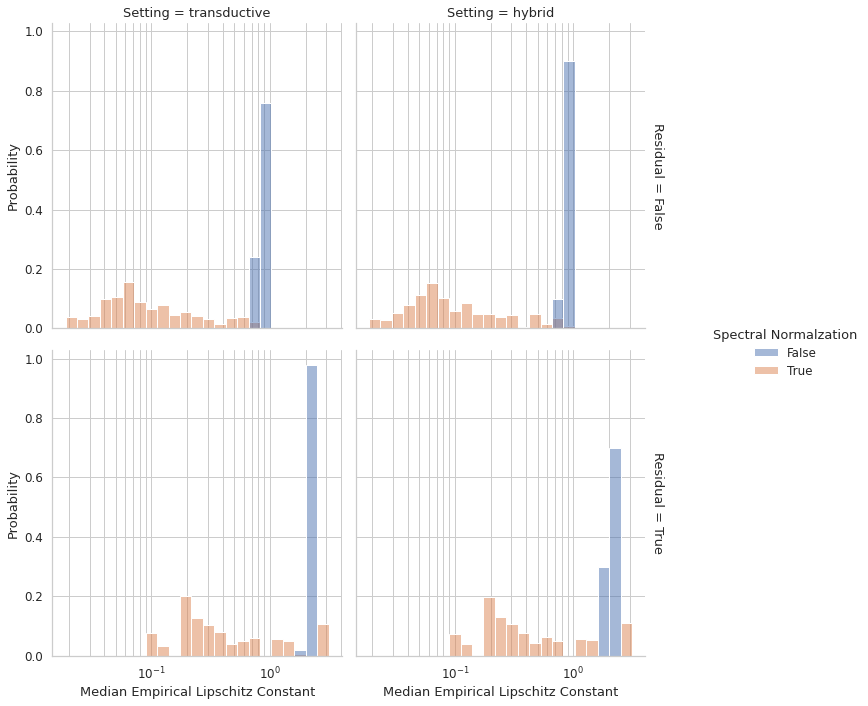

In [17]:


sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.displot(data = df, x=LIPSCHITZ, hue = SPECTRAL_NORM, col = SETTING, row=RESIDUAL,
                kind='hist', facet_kws = {'margin_titles' : True}, stat='probability', log_scale=True, common_norm=False)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

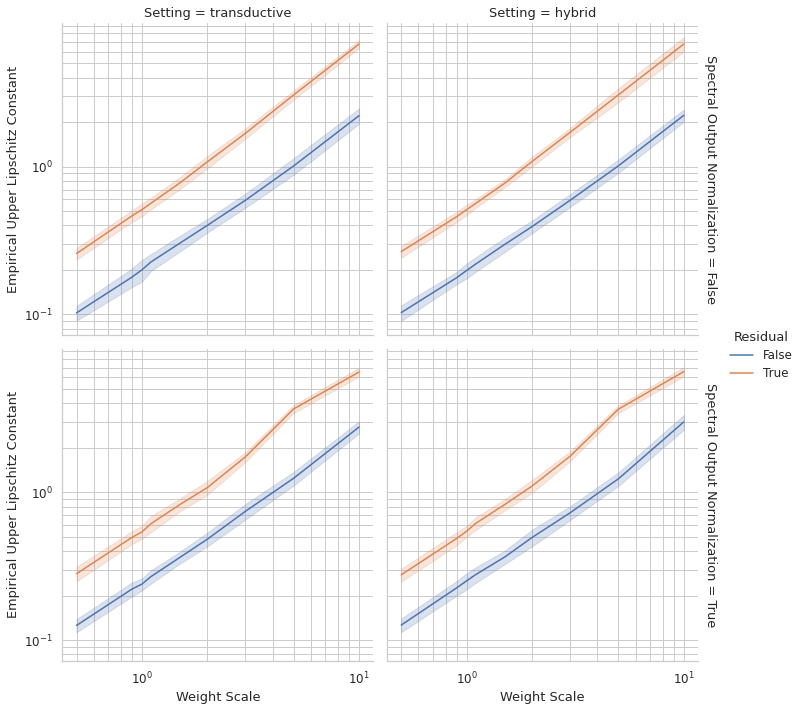

In [18]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df, x = WEIGHT_SCALE, y = LIPSCHITZ_MAX, hue = RESIDUAL, col = SETTING, 
                row = NORMALIZE_OUTPUT, kind='line', facet_kws = {'margin_titles' : True}, ci='sd')
g.set(xscale='log', yscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
    ax.yaxis.grid(True, which='minor')

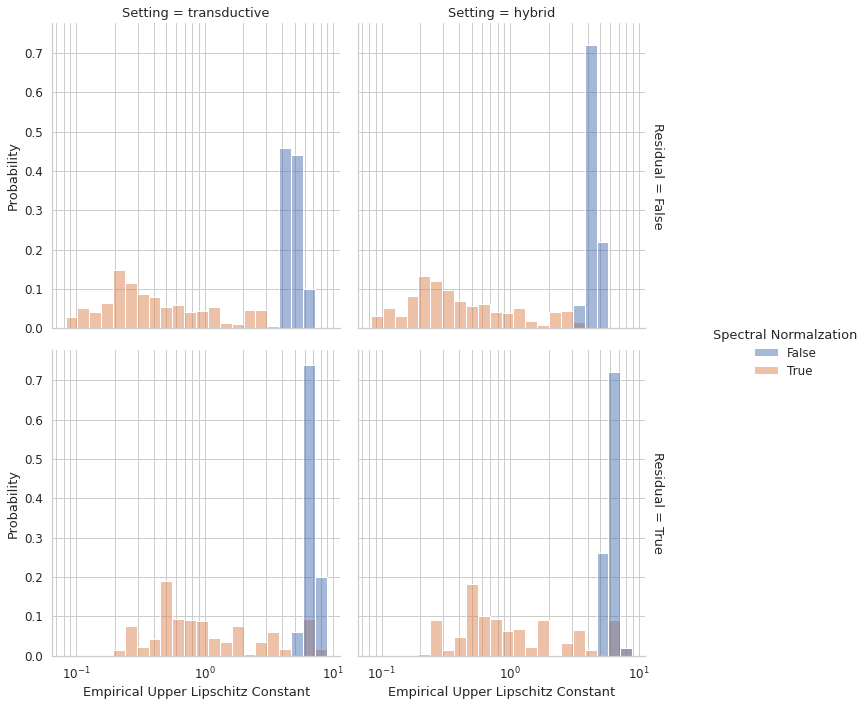

In [19]:


sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.displot(data = df, x=LIPSCHITZ_MAX, hue = SPECTRAL_NORM, col = SETTING, row=RESIDUAL,
                kind='hist', facet_kws = {'margin_titles' : True}, stat='probability', log_scale=True, common_norm=False)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

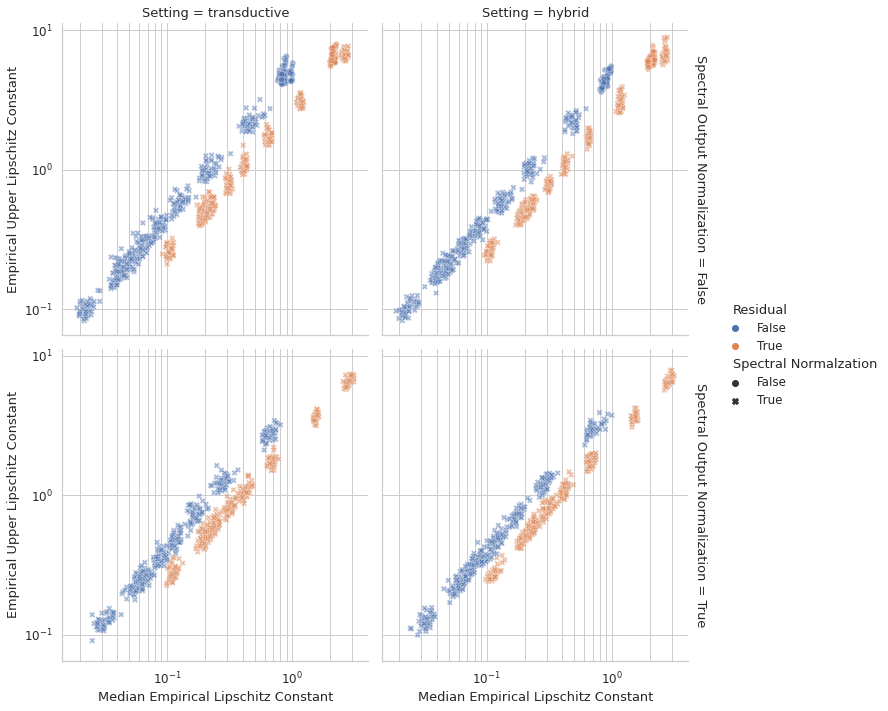

In [20]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df, x = LIPSCHITZ, y = LIPSCHITZ_MAX, hue = RESIDUAL, col = SETTING, 
                row = NORMALIZE_OUTPUT, kind='scatter', facet_kws = {'margin_titles' : True}, alpha=0.5, style=SPECTRAL_NORM)
g.set(xscale='log', yscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

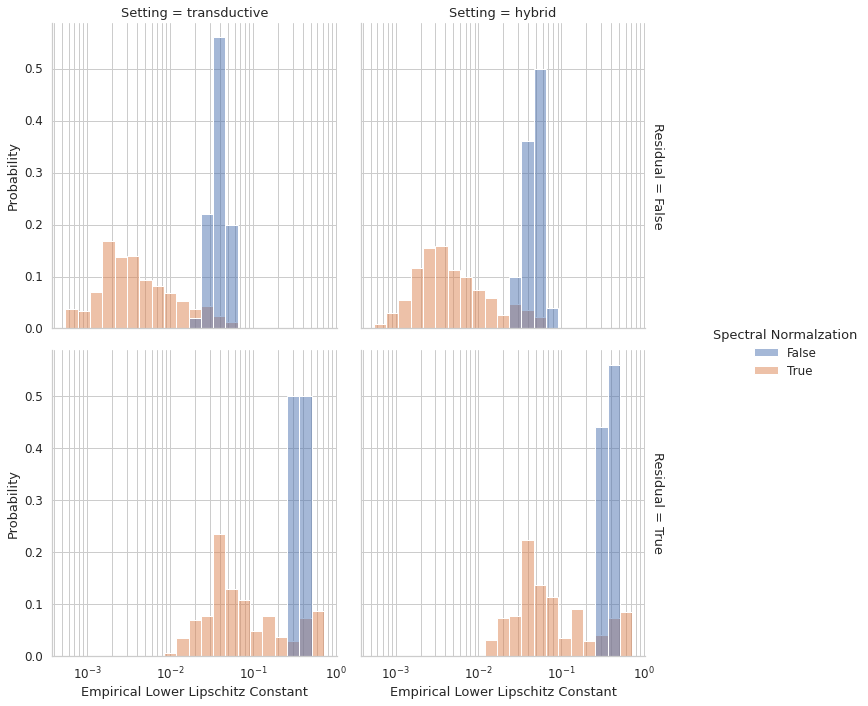

In [21]:


sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.displot(data = df, x=LIPSCHITZ_MIN, hue = SPECTRAL_NORM, col = SETTING, row=RESIDUAL,
                kind='hist', facet_kws = {'margin_titles' : True}, stat='probability', log_scale=True, common_norm=False)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

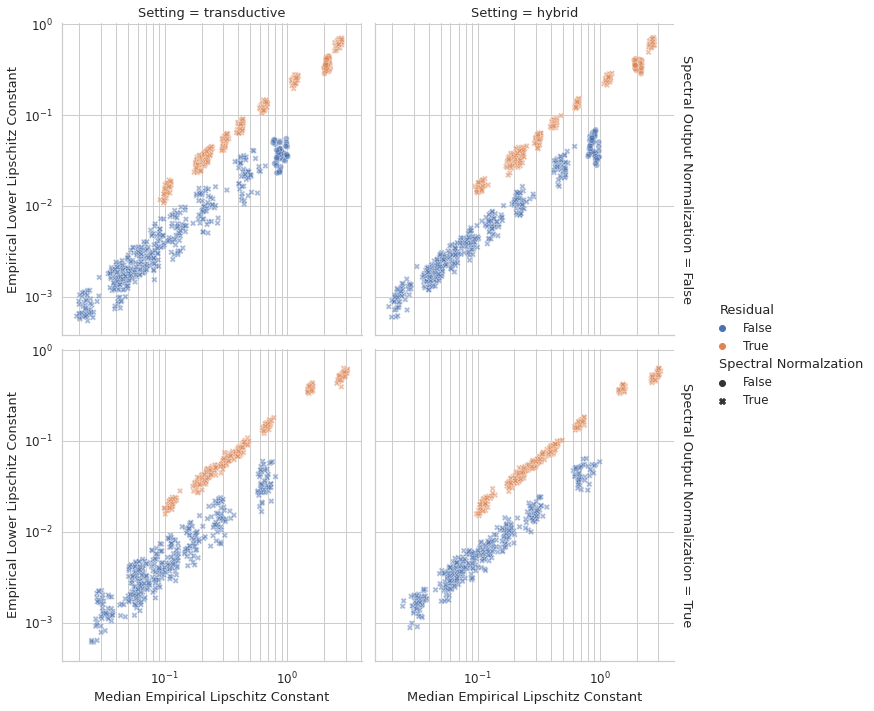

In [22]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df, x = LIPSCHITZ, y = LIPSCHITZ_MIN, hue = RESIDUAL, col = SETTING, 
                row = NORMALIZE_OUTPUT, kind='scatter', facet_kws = {'margin_titles' : True}, alpha=0.5, style=SPECTRAL_NORM)
g.set(xscale='log', yscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

## Correlation of Accuarcy and Calibration with Lipschitz Constant

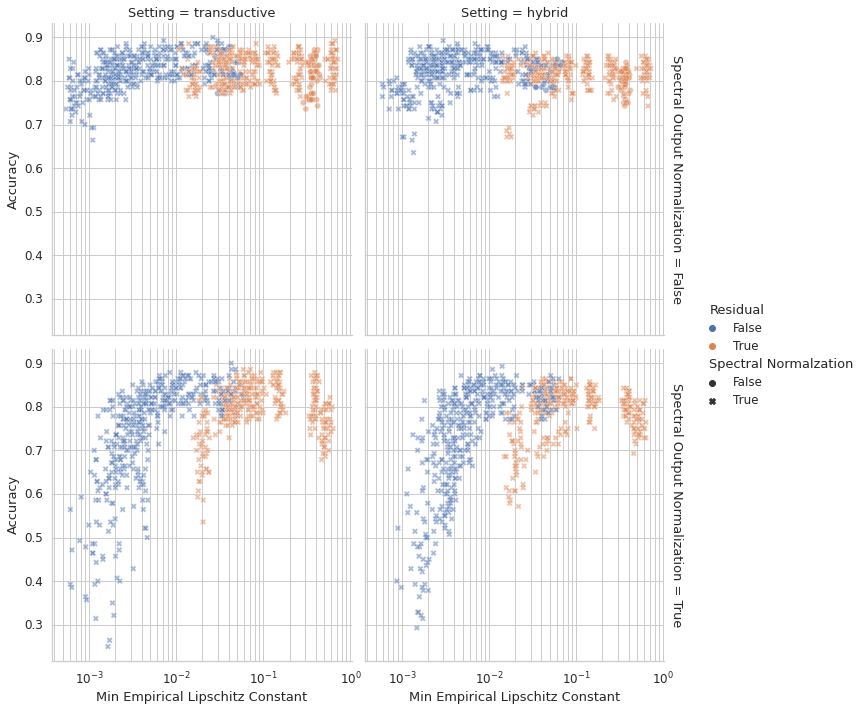

In [32]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df, x = LIPSCHITZ_MIN, y = ACCURACY, hue = RESIDUAL, col = SETTING, 
                row = NORMALIZE_OUTPUT, kind='scatter', facet_kws = {'margin_titles' : True}, alpha=0.5, style=SPECTRAL_NORM)
g.set(xscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

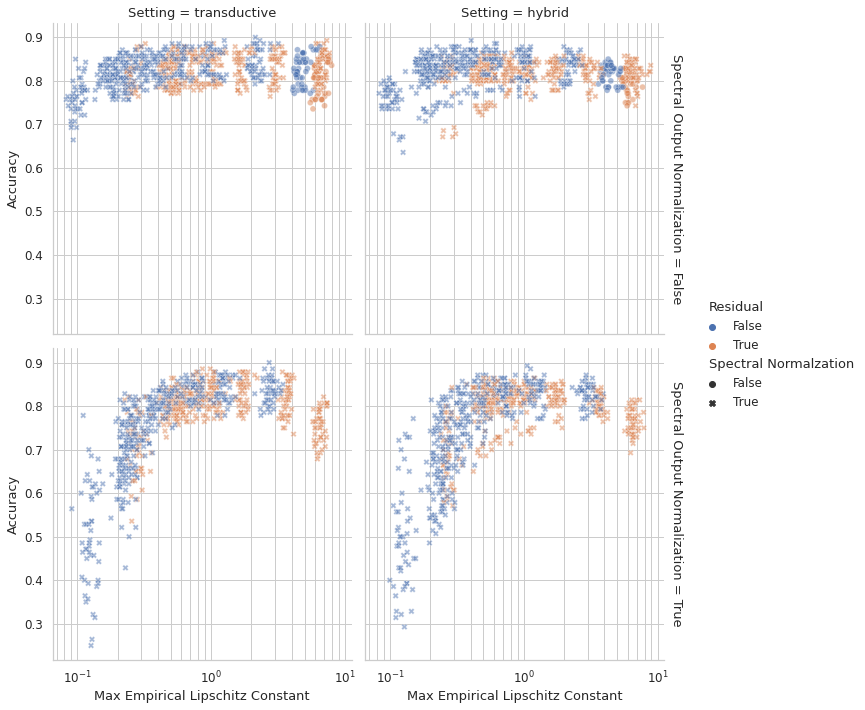

In [22]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df, x = LIPSCHITZ_MAX, y = ACCURACY, hue = RESIDUAL, col = SETTING, 
                row = NORMALIZE_OUTPUT, kind='scatter', facet_kws = {'margin_titles' : True}, alpha=0.5, style=SPECTRAL_NORM)
g.set(xscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

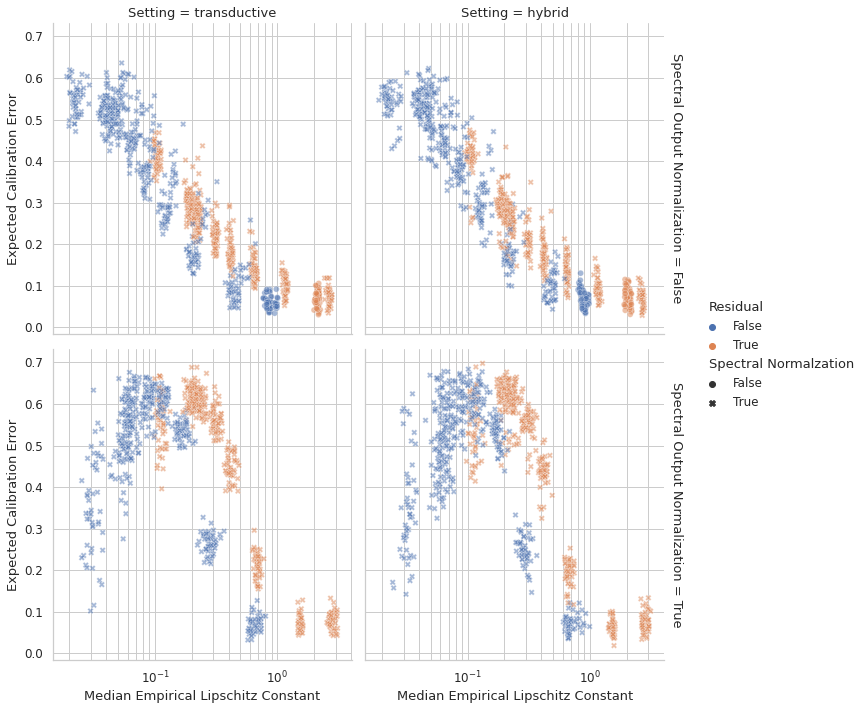

In [23]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df, x = LIPSCHITZ, y = ECE, hue = RESIDUAL, col = SETTING, 
                row = NORMALIZE_OUTPUT, kind='scatter', facet_kws = {'margin_titles' : True}, alpha=0.5, style=SPECTRAL_NORM)
g.set(xscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

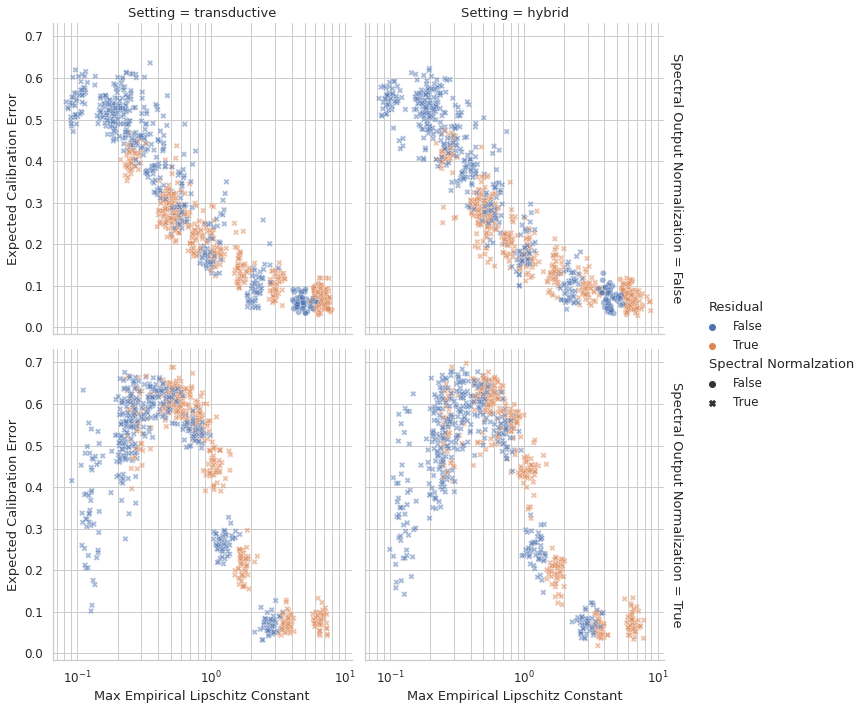

In [24]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df, x = LIPSCHITZ_MAX, y = ECE, hue = RESIDUAL, col = SETTING, 
                row = NORMALIZE_OUTPUT, kind='scatter', facet_kws = {'margin_titles' : True}, alpha=0.5, style=SPECTRAL_NORM)
g.set(xscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

## Effect of Lipschitz Constant on OOD-Detection

## Feature Density

### AUROC vs Median Lipschitz Constant

#### Hybrid Setting

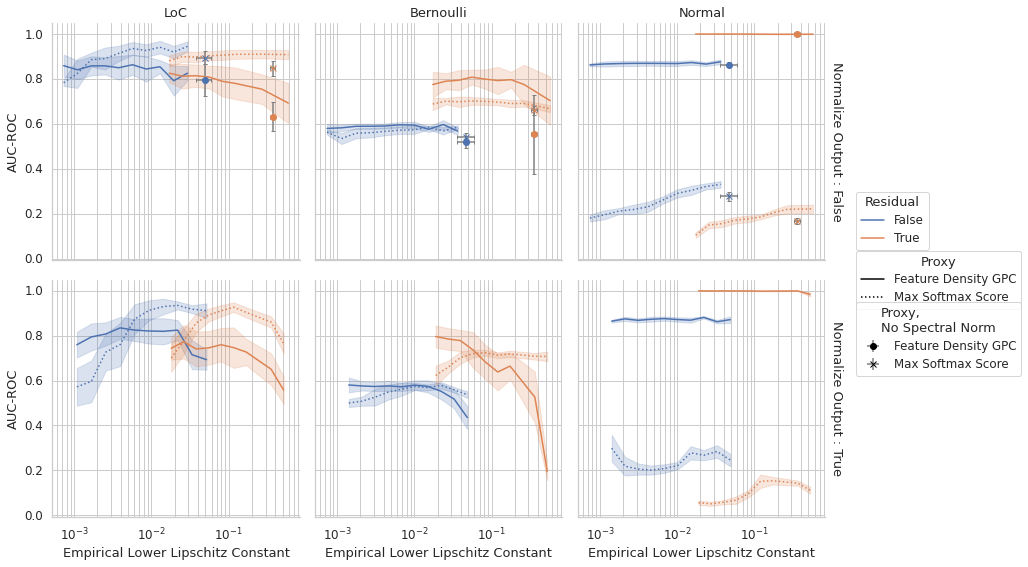

In [26]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
    df_auroc[(df_auroc[SETTING] == HYBRID)],
    x = LIPSCHITZ_MIN, y = AUROC, col = OOD, row = NORMALIZE_OUTPUT, hue = RESIDUAL, style = PROXY)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = 'Normalize Output : {row_name}', col_template = '{col_name}')

#### Transductive Setting

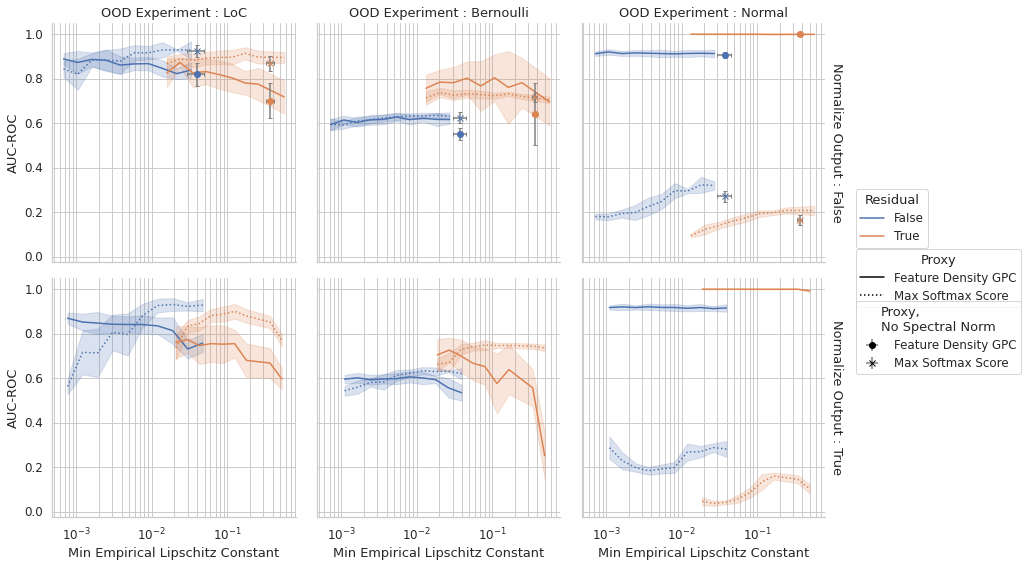

In [34]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
    df_auroc[(df_auroc[SETTING] == TRANSDUCTIVE)],
    x = LIPSCHITZ_MIN, y = AUROC, col = OOD, row = NORMALIZE_OUTPUT, hue = RESIDUAL, style = PROXY)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = 'Normalize Output : {row_name}', col_template = 'OOD Experiment : {col_name}')

### AUROC vs Max Lipschitz Constant

#### Hybrid Setting

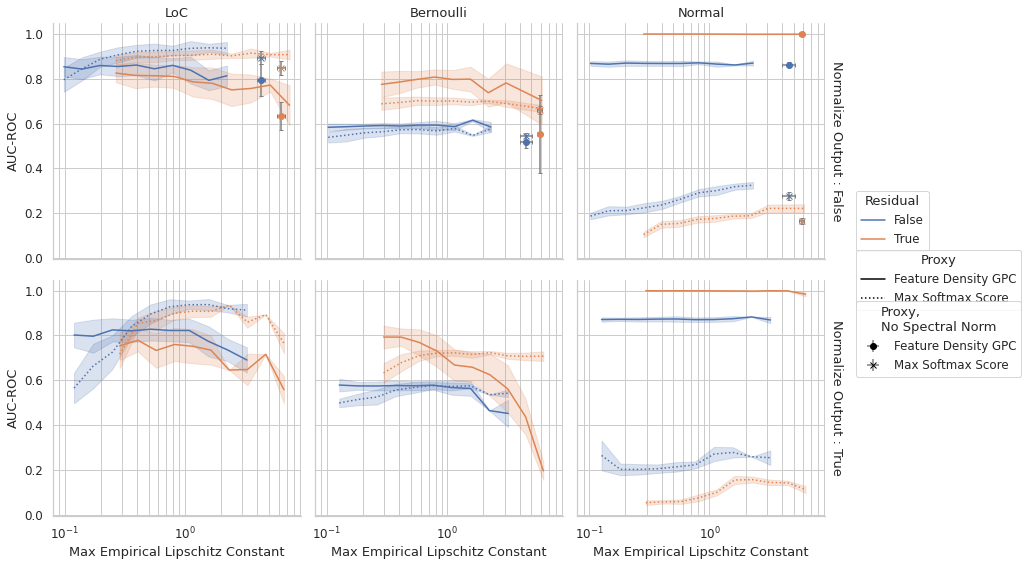

In [27]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
    df_auroc[(df_auroc[SETTING] == HYBRID)],
    x = LIPSCHITZ_MAX, y = AUROC, col = OOD, row = NORMALIZE_OUTPUT, hue = RESIDUAL, style = PROXY)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = 'Normalize Output : {row_name}', col_template = '{col_name}')

#### Transductive Setting

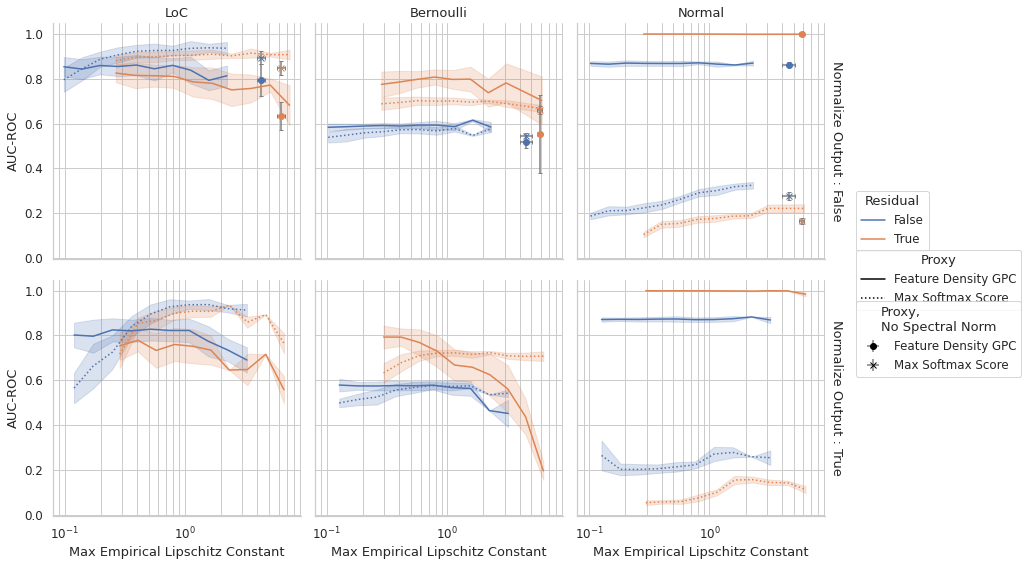

In [28]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
    df_auroc[(df_auroc[SETTING] == HYBRID)],
    x = LIPSCHITZ_MAX, y = AUROC, col = OOD, row = NORMALIZE_OUTPUT, hue = RESIDUAL, style = PROXY)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = 'Normalize Output : {row_name}', col_template = '{col_name}')

### Importance of accuracy for AUC-ROC LoC

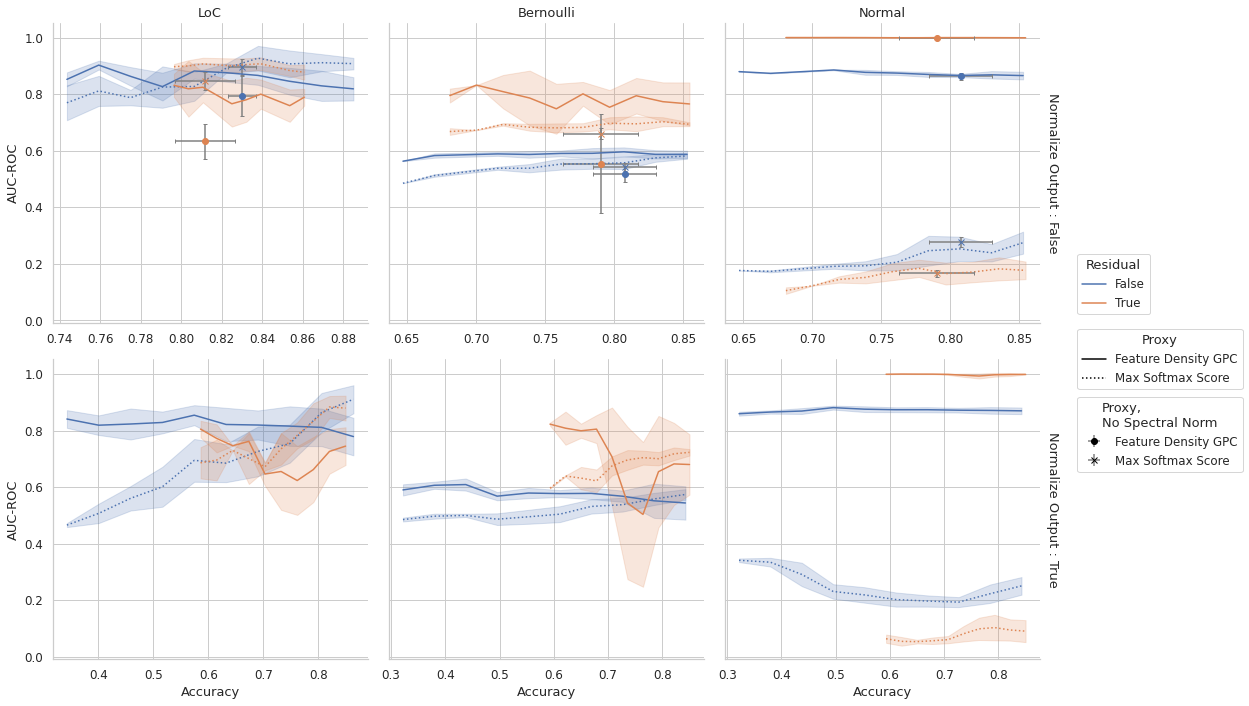

In [29]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
    df_merged[(df_merged[SETTING] == HYBRID)],
    x = ACCURACY, y = AUROC, col = OOD, row = NORMALIZE_OUTPUT, hue = RESIDUAL, style = PROXY, log_x = False,

    facet_kws = {'margin_titles' : True, 'height' : 5, 'sharex' : False}
)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = 'Normalize Output : {row_name}', col_template = '{col_name}')

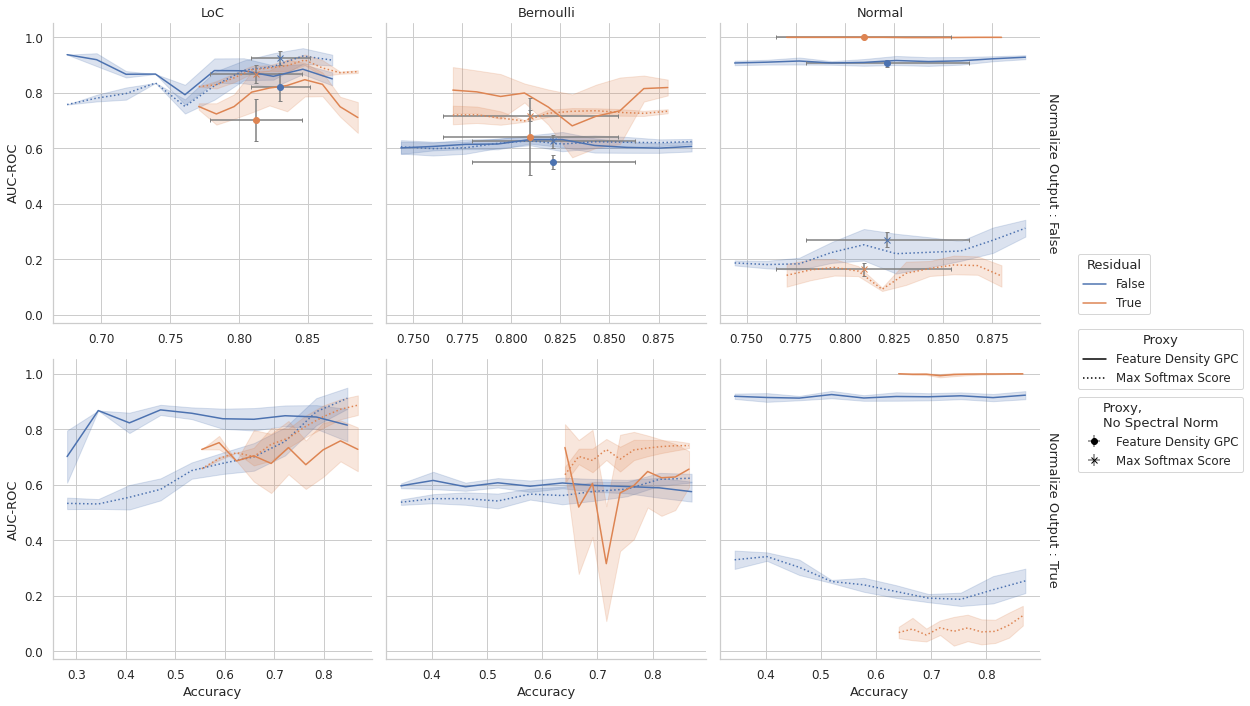

In [30]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
    df_merged[(df_merged[SETTING] == TRANSDUCTIVE)],
    x = ACCURACY, y = AUROC, col = OOD, row = NORMALIZE_OUTPUT, hue = RESIDUAL, style = PROXY, log_x = False,

    facet_kws = {'margin_titles' : True, 'height' : 5, 'sharex' : False}
)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = 'Normalize Output : {row_name}', col_template = '{col_name}')